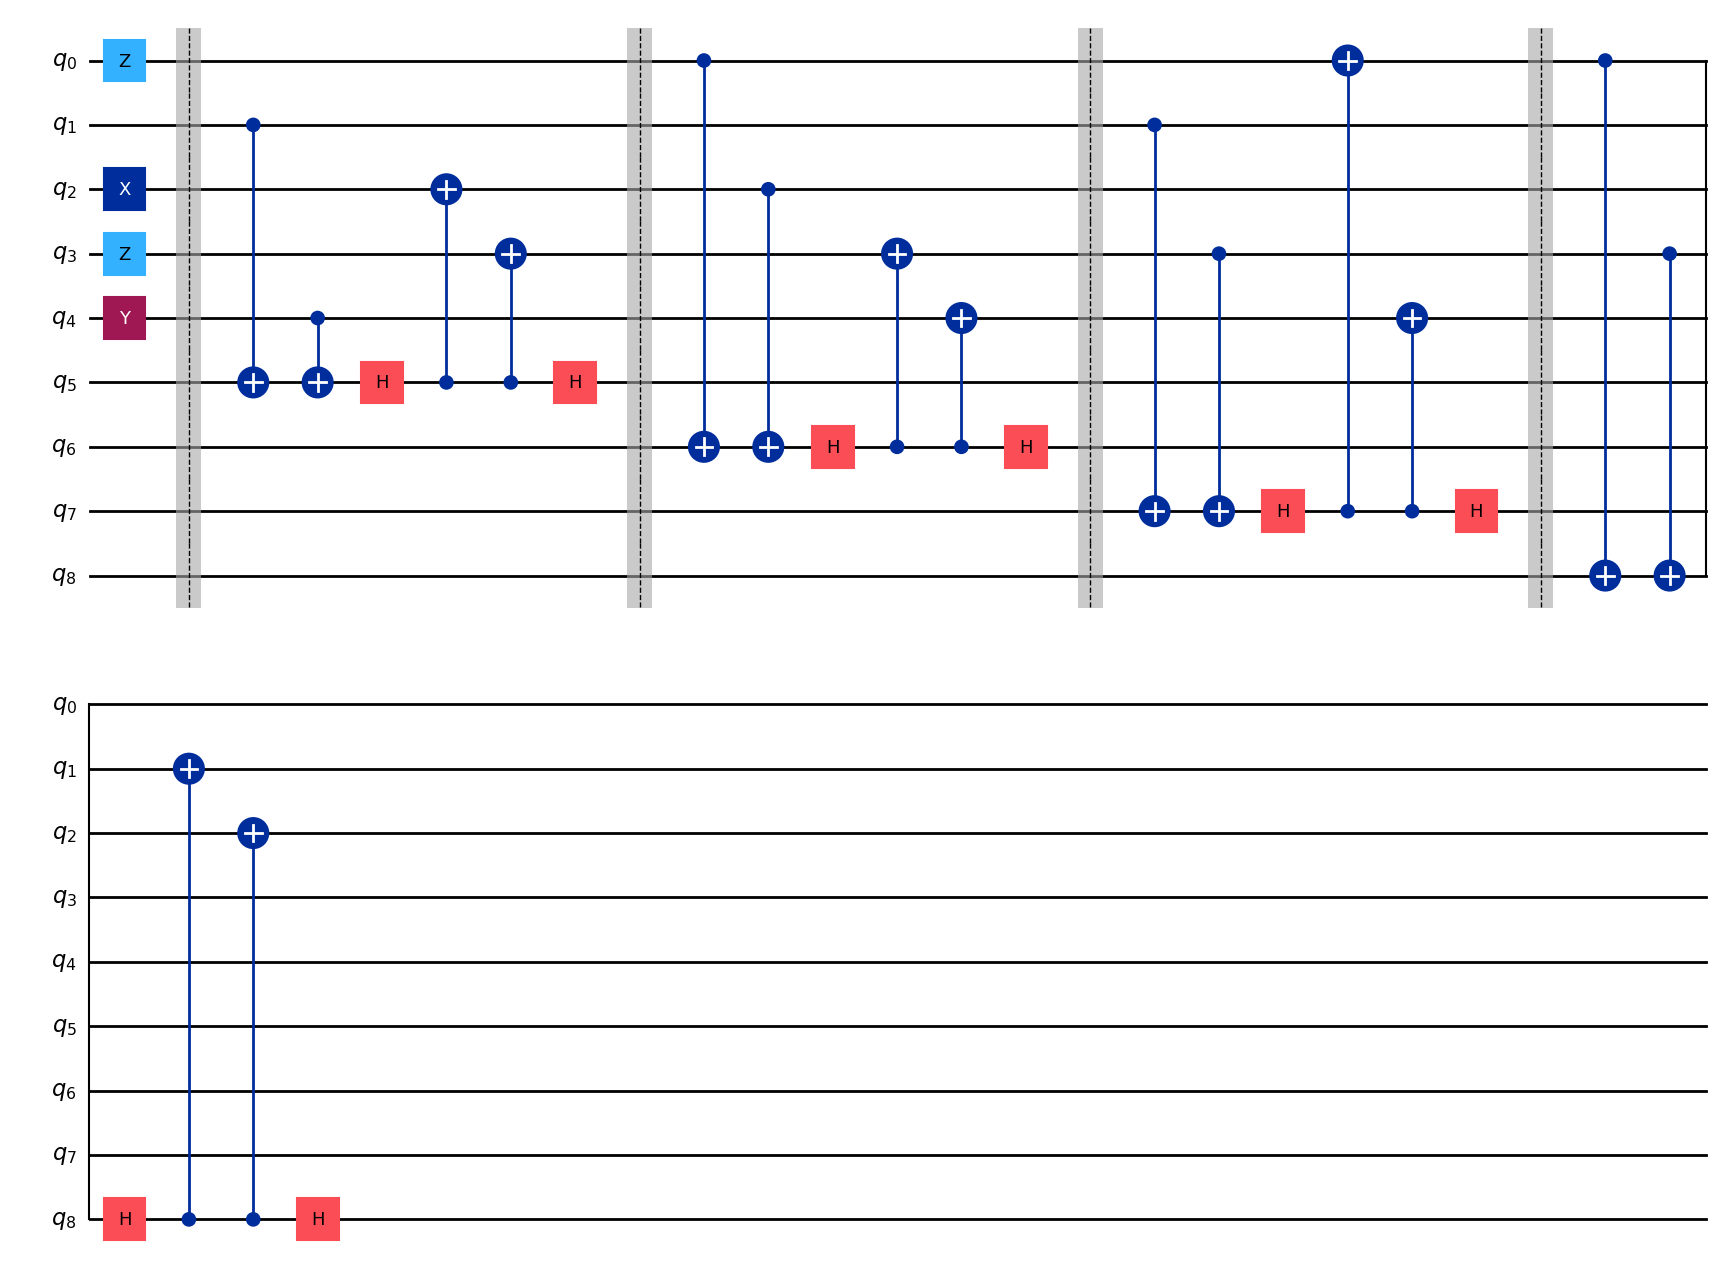

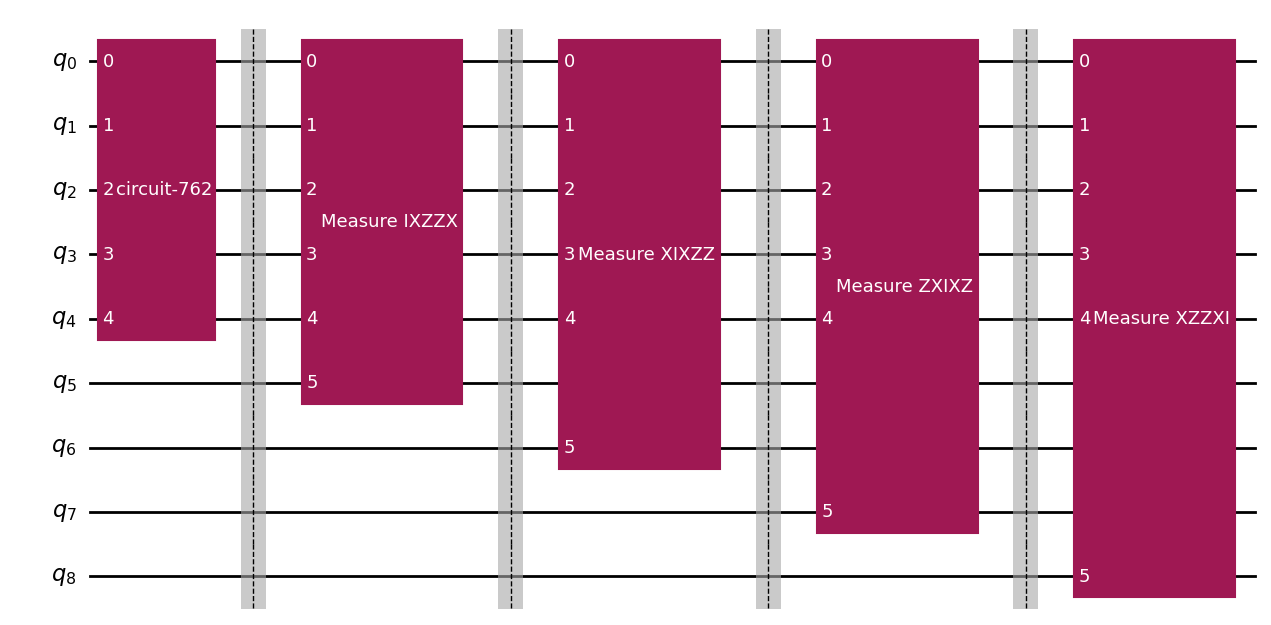

Statevector([0.+6.25000000e-02j, 0.+6.25000000e-02j, 0.-6.25000000e-02j,
             0.+6.25000000e-02j, 0.+6.25000000e-02j, 0.+6.25000000e-02j,
             0.-6.25000000e-02j, 0.+6.25000000e-02j, 0.-6.25000000e-02j,
             0.+6.25000000e-02j, 0.+6.25000000e-02j, 0.+6.25000000e-02j,
             0.-6.25000000e-02j, 0.+6.25000000e-02j, 0.+6.25000000e-02j,
             0.+6.25000000e-02j, 0.-1.43709198e-18j, 0.-1.43709198e-18j,
             0.-2.62761796e-18j, 0.+2.62761796e-18j, 0.-1.43709198e-18j,
             0.-1.43709198e-18j, 0.-2.62761796e-18j, 0.+2.62761796e-18j,
             0.+2.62761796e-18j, 0.-2.62761796e-18j, 0.+1.43709198e-18j,
             0.+1.43709198e-18j, 0.+2.62761796e-18j, 0.-2.62761796e-18j,
             0.+1.43709198e-18j, 0.+1.43709198e-18j, 0.-6.25000000e-02j,
             0.-6.25000000e-02j, 0.-6.25000000e-02j, 0.+6.25000000e-02j,
             0.+6.25000000e-02j, 0.+6.25000000e-02j, 0.+6.25000000e-02j,
             0.-6.25000000e-02j, 0.+6.25000000e-02j

In [68]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer.noise import pauli_error

p = 0.3
# Stabilizers (cyclic form) and logical Z
G = ["IXZZX", "XIXZZ", "ZXIXZ", "XZZXI"]
ZL = Pauli("ZZZZZ")
n = len(G[0])

# Logical |0_L> for the [[5,1,3]] code
plus_terms  = ["00000","10010","01001","10100","01010","00101"]
minus_terms = ["11011","00110","11000","11101","00011","11110","01111","10001","01100","10111"]

amps = np.zeros(32, dtype=complex)
for b in plus_terms:
    amps[int(b,2)] += 1/4
for b in minus_terms:
    amps[int(b,2)] -= 1/4

sv = Statevector(amps)
sv = sv.tensor(Statevector.from_label('0' * len(G)))

def pauli_error_on_all_data_qubits(p) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    for i in range(n):
        if random.random() < 3*p:
            error_type = random.choice(['X', 'Y', 'Z'])
            if error_type == 'X':
                qc.x(i)
            elif error_type == 'Y':
                qc.y(i)
            elif error_type == 'Z':
                qc.z(i)

    return qc

def measure_stabilizer(p_string) -> QuantumCircuit:
    
    x_indices = np.zeros(n, dtype=int)
    z_indices = np.zeros(n, dtype=int)
    qc = QuantumCircuit(n + 1, name=f"Measure {p_string}")

    for i, p in enumerate(p_string):
        if p == 'X':
            x_indices[i] = 1
        elif p == 'Z':
            z_indices[i] = 1

    for i in range(n):
        if x_indices[i] == 1:
            qc.cx(i, n)

    qc.h(n)
    for i in range(n):
        if z_indices[i] == 1:
            qc.cx(n, i)

    qc.h(n)

    return qc

qc_5q = QuantumCircuit(n + len(G))
qc_5q.append(pauli_error_on_all_data_qubits(p), range(n))

# qc_5q.initialize(sv.data, range(5))
for i in range(len(G)):
    qc_5q.barrier()
    qc_5q.append(measure_stabilizer(G[i]), list(range(n)) + [n + i])

# display(measure_stabilizer(G[0]).draw(output="mpl"))
display(qc_5q.decompose().draw(output="mpl"))
display(qc_5q.draw(output="mpl"))

sv.evolve(qc_5q)